# Tutorial: Two-Class image categorization with STDP/R-STDP
Here, we provide a brief tutorial on designing, training, and evaluating a two-layer spiking neural network (SNN). The structure of this network is similar those proposed by <a href="https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.0030031"> Masquelier and Thorpe (PLoS Comput Biol, 2007)</a> and <a href="https://ieeexplore.ieee.org/document/8356226">Mozafari et al (IEEE TNNL, 2018)</a>.

The network in this tutorial has the following specifications:
 - **Input Images**: Grayscale images in single scale
 - **Layer S1**: 4 Gabor filter in different orientations, conversion to spike-wave tensor
 - **Layer C1**: Local pooling
 - **Layer S2**: Trainable convolutional layer employing STDP or R-STDP

The target task is the categorization of cups and dogs images taken from the <a href="http://datasets.d2.mpi-inf.mpg.de/eth80/eth80-cropped-close128.tgz"> ETH-80 (cropped-close-128)</a> dataset. Here, we down-scaled images by half for the sake of a faster execution (<a href="https://github.com/miladmozafari/SpykeTorch/tree/master/dataset/eth">download</a>).

**_Note_**_: In order to easily split different parts of the code, we do not create classes and methods for our network. The goal of this tutorial is to demonstrate useful features of SpykeTorch and does not provide a clean and efficient implementation design._

## 0. Requirements
In order to run this tutorial or use SpykeTorch in general, there are several things that you need to install on your machine. To make the life easier, we recommend installing [**Anaconda**](https://www.anaconda.com/distribution/). It is a Python distribution that includes all of the scientific packages and leaves no worries for not only this tutorial but also other SpykeTorch's scripts. All the dependecies are listed in the `requirements.txt` file. You need to install `scikit-learn` as an additional requirement for this tutorial.

SpykeTorch is developed based on **PyTorch**. Thus, in addition to Anaconda, you must install PyTorch package. Through [PyTorch's web-page](https://pytorch.org/) you can easily find the install script based on the configuration of the machine you have.

When you are done with the requirements, you can clone this repository and start using this tutorial via Jupyter. To this end, open a terminal at the repo's location and enter this command: <br> `jupyter notebook` <br> After a few seconds, a new tab in your default browser will be opened and you can select this notebook to work with.

## 1. Layer S1
Implementation of layer S1 consists of loading images and applying series of transformations to convert an image into spike-wave tensor. We will load images with the help of Torchvision's `ImageFolder` dataset and PyTorch's `DataLoader`, but first, we need to prepare the image transform.

The whole pipeline of image transformation is as follows:<br> image >> grayscale image >> PyTorch's 3D tensor >> 4D tensor (time dimension) >> Gabor filters >> lateral inhibition >> intencity-to-latency encoding.

`SpykeTorch.utils` provides `Filter` class which is suitable for applying different filter kernels on a 4D input tensor. Here, we create a `Filter` object by providing a list of 4 Gabor filter kernels. We involve negative edges into our computations by setting `use_abs` to `True`.

In [1]:
import matplotlib.pyplot as plt

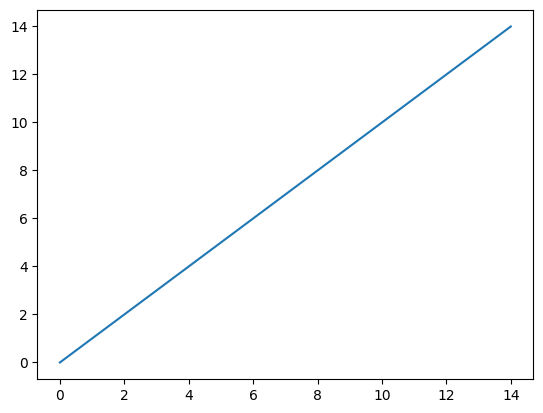

In [2]:
# test plot with matplotlib y=x
plt.plot(range(0, 15), range(0, 15))

In [1]:
import SpykeTorch.utils as utils

kernels = [	utils.GaborKernel(window_size = 3, orientation = 45+22.5),
            utils.GaborKernel(3, 90+22.5),
            utils.GaborKernel(3, 135+22.5),
            utils.GaborKernel(3, 180+22.5)]
filter = utils.Filter(kernels, use_abs = True)

To add a new dimension to the tensor, we use the `unsqueeze` method provided by PyTorch. This new extra dimension will be considered as the first dimension of the tensor.

In [2]:
def time_dim(input):
    return input.unsqueeze(0)

Grayscale and Tensor conversion are provided by Torchvision. `SpykeTorch.functional.pointwise_inhibition` implements lateral inhibition among features and `SpykeTorch.utils.Intensity2Latency` object generates the spike-wave tensor based on intensities. All in all, the whole image to spike-wave transform can be written as a composition of several transforms:

In [3]:
import SpykeTorch.utils as utils
import SpykeTorch.functional as sf
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.ToTensor(),
        time_dim,
        filter,
        sf.pointwise_inhibition,
        utils.Intensity2Latency(number_of_spike_bins = 15, to_spike = True)
    ]
)

Now that the transform is ready, we can create the dataset object. Here, we use `torchvision.datasets.ImageFolder` class to load an image dataset consist of two categories: "cup" and "dog". We show how the transform works by visualizing a sample image with and without application of the transform.

Without transform:

In [4]:
from torchvision.datasets import ImageFolder
import random

dataset = ImageFolder("dataset/eth")
sample_idx = random.randint(0, len(dataset) - 1)

In [5]:
dataset[sample_idx][0].size

(64, 64)

In [7]:
import matplotlib.pyplot as plt

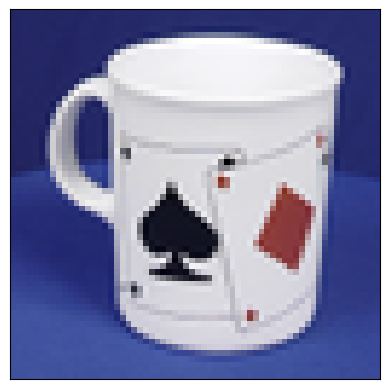

In [8]:
# plotting the sample image
ax = plt.subplot(1,1,1)
plt.setp(ax, xticklabels=[])
plt.setp(ax, yticklabels=[])
plt.xticks([])
plt.yticks([])
plt.imshow(dataset[sample_idx][0])
plt.show()

To show the output of the transform, i.e. the corresponding spike-wave tensor, we plot each time-step separately for each feature until the 5th time-step. We also plot the accumulation of spikes over all of the features.

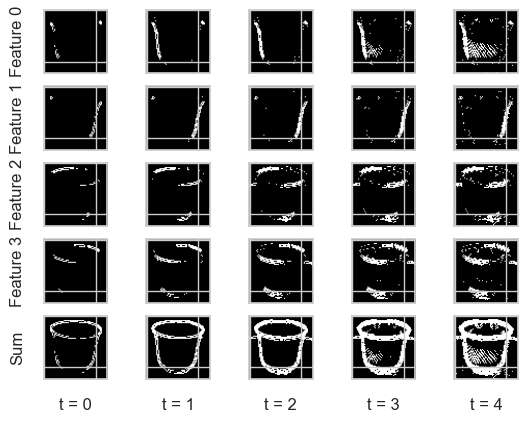

In [19]:
import numpy as np
import seaborn as sns

dataset = ImageFolder("dataset/eth", transform) # adding transform to the dataset
sns.set_theme(style="whitegrid")
# plt.style.use('seaborn-white')
plt_idx = 0
sw = dataset[sample_idx][0]
for f in range(4):
    for t in range(5):
        plt_idx += 1
        ax = plt.subplot(5, 5, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 0:
            ax.set_ylabel('Feature ' + str(f))
        plt.imshow(sw[t,f].numpy(),cmap='gray')
        if f == 3:
            ax = plt.subplot(5, 5, plt_idx + 5)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 0:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(sw[t].sum(dim=0).numpy(),cmap='gray')
plt.show()

To manage data loading, we use `DataLoader` provided by `torch.utils.data`. Here, we shuffle and split the whole dataset into two training (75%) and testing (25%) parts. Then, the corresponding indices will be given to data loaders.

In [20]:
# splitting training and testing sets
indices = list(range(len(dataset)))
random.shuffle(indices)
split_point = int(0.75*len(indices))
train_indices = indices[:split_point]
test_indices = indices[split_point:]
print("Size of the training set:", len(train_indices))
print("Size of the  testing set:", len(test_indices))

Size of the training set: 615
Size of the  testing set: 205


Since the transform from image to spike-wave tensor is time-consuming and static, we use `SpykeTorch.utils.CacheDataset` to cache spike-wave tensors for each image. `CacheDataset` is a wrapper that can work with other PyTorch's `dataset` objects as well.

In [21]:
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

dataset = utils.CacheDataset(dataset)
train_loader = DataLoader(dataset, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, sampler=SubsetRandomSampler(test_indices))

## 2. Layers C1 and S2
As mentioned before, C1 is a local pooling and S2 is a trainable convolutional layer. `SpykeTorch.snn` provides appropriate modules for each.

Layer C1 performs local pooling with window-size = 3 and stride = 2.

In [22]:
import SpykeTorch.snn as snn

pool = snn.Pooling(kernel_size = 3, stride = 2)

Now we create a convolutional layer with 20 features and kernel-size equal to the size of the C1's output. Since Gabor filters are of size 3, each 64x64 input image shrinks to 62x62 after S1. Then by applying the pooling, the size of the C1's output will be 30x30.

In [23]:
conv = snn.Convolution(in_channels=4, out_channels=20, kernel_size=30)

## 3. Unsupervised Learning
In this section, we show how to train and evaluate layer S2 using STDP. First, we assign STDP learning rule to layer S2:

In [24]:
stdp = snn.STDP(conv_layer = conv, learning_rate = (0.05, -0.015))

### 3.1 Training
Each input spike-wave tensor (given by the data loader) will be passed through pooling (C1) and convolutional (S2) layers. The output of S2 denotes the trajectory of potentials over all of the time-steps. In order to convert them to spikes, we call `SpykeTorch.functional.fire` on the potentials with the desired threshold. When the output is ready, we find winners (here we have only one winner) to perform plasticity. `SpykeTorch.functional.get_k_winners` function, finds winner neurons first based on the earliest spike and then, based on the maximum potential. By providing input and output spike-wave and the potential tensors as well as the winners, STDP can be applied on layer S2.

In [25]:
print("Starting Unsupervised Training ...")
for iter in range(30):
    print('\rIteration:', iter, end="")
    for data,_ in train_loader:
        for x in data:
            x = pool(x)
            p = conv(x)
            o, p = sf.fire(p, 20, return_thresholded_potentials=True)
            winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
            stdp(x, p, o, winners)
print()
print("Unsupervised Training is Done.")

Starting Unsupervised Training ...
Iteration: 29
Unsupervised Training is Done.


### 3.2 Reconstructing Features
To reconstruct S2 features, one can use the provided functions in `SpykeTorch.visualization` module. `get_deep_feature` function receives the features extracted by the previous layer and generates the recunstructions for the current layer. It also outputs the accumulative stride until the current layer to be used when reconstructing the features of the next layer (if any).

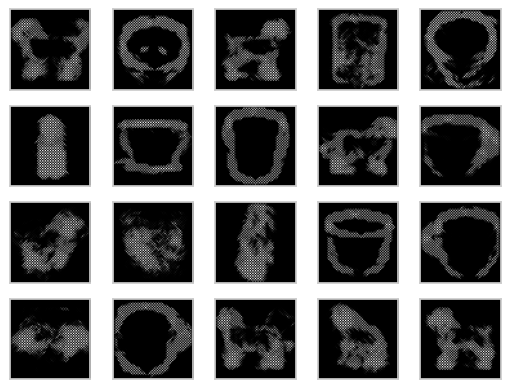

In [26]:
import SpykeTorch.visualization as vis
import torch

feature = torch.stack([k() for k in kernels])
cstride = (1,1)
# C1 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (3, 3), (2, 2))
# S2 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (30,30), (1,1), conv.weight)

feature_idx = 0
for r in range(4):
    for c in range(5):
        ax = plt.subplot(4, 5, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
plt.show()

### 3.3 Evaluation
Since we performed unsupervised training, we need to use an external classifier to do the inference. Here, we use the linear SVM provided by `sklearn`. Before using the SVM, we need to prepare the training and testing data (network's output vectors). We extract two kinds of vectors from S2: (1) potentials, and (2) binary spikes.

**Training vectors:**

In [27]:
train_x_spike = []
train_x_pot = []
train_y = []
for data,targets in train_loader:
    for x,t in zip(data, targets):
        x = pool(x)
        p = conv(x)
        o = sf.fire(p, 20)
        train_x_spike.append(o.reshape(-1).cpu().numpy())
        train_x_pot.append(p.reshape(-1).cpu().numpy())
        train_y.append(t)
train_x_spike = np.array(train_x_spike)
train_x_pot = np.array(train_x_pot)
train_y = np.array(train_y)

**Testing vectors:**

In [28]:
test_x_spike = []
test_x_pot = []
test_y = []
for data,targets in test_loader:
    for x,t in zip(data, targets):
        x = pool(x)
        p = conv(x)
        o = sf.fire(p, 20)
        test_x_spike.append(o.reshape(-1).cpu().numpy())
        test_x_pot.append(p.reshape(-1).cpu().numpy())
        test_y.append(t)
test_x_spike = np.array(test_x_spike)
test_x_pot = np.array(test_x_pot)
test_y = np.array(test_y)

**Classifier:**

In [29]:
from sklearn.svm import LinearSVC

clf_spike = LinearSVC(max_iter=100000)
clf_pot = LinearSVC(max_iter=100000)
clf_spike.fit(train_x_spike, train_y)
clf_pot.fit(train_x_pot, train_y)

c:\Users\aidin\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\aidin\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(max_iter=100000)

**Inference:**

In [30]:
predict_spike = clf_spike.predict(test_x_spike)
predict_pot = clf_pot.predict(test_x_pot)

error_spike = np.abs(test_y - predict_spike).sum()
error_pot = np.abs(test_y - predict_pot).sum()
print("    Spike-based error:", error_spike/len(predict_spike))
print("Potential-based error:", error_pot/len(predict_pot))

    Spike-based error: 0.13170731707317074
Potential-based error: 0.0


## 4. Reinforcement Learning
In this section, we show how to train and evaluate layer S2 using R-STDP. First, we reset the weights of S2 and assing it a new `SpykeTorch.snn.STDP` object as the anti-STDP part of the R-STDP.

In [31]:
conv.reset_weight()
anti_stdp = snn.STDP(conv_layer = conv, learning_rate = (-0.05, 0.0005))

 We also need a mapping from each S2 feature to a category. Here, we assing the first 10 to "cup" class and the second 10 to "dog" class.

In [32]:
feature2class = [0] * 10 + [1] * 10
print(feature2class)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### 4.1 Training
Again, each spike-wave tensor is passed through C1 and S2 and the only one winner is chosen. Here, the classification or the decision of the network is the category assigned to the winner feature. If the decision is right (wrong), stdp (anti-stdp) will be applied.

In [33]:
print("Starting Reinforcement Learning ...")
for iter in range(20):
    print('\rIteration:', iter, end="")
    for data,targets in train_loader:
        for x,t in zip(data, targets):
            x = pool(x)
            p = conv(x)
            o, p = sf.fire(p, 20, return_thresholded_potentials=True)
            winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
            if len(winners) != 0:
                if feature2class[winners[0][0]] == t:
                    stdp(x, p, o, winners)
                else:
                    anti_stdp(x, p, o, winners)
print()
print("Reinforcement Learning is Done.")

Starting Reinforcement Learning ...
Iteration: 19
Reinforcement Learning is Done.


### 4.2 Reconstructing Features
We use the same procedure as the one in unsupervised learning section.

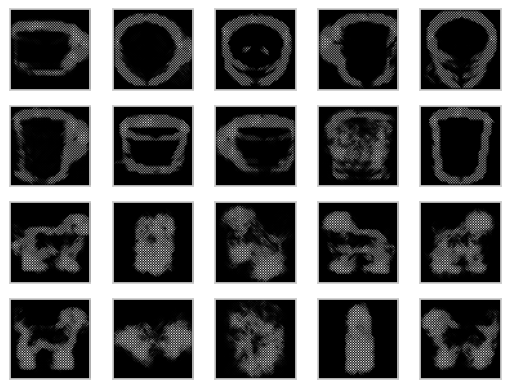

In [34]:
feature = torch.stack([k() for k in kernels])
cstride = (1,1)
# C1 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (3, 3), (2, 2))
# S2 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (30,30), (1,1), conv.weight)

feature_idx = 0
for r in range(4):
    for c in range(5):
        ax = plt.subplot(4, 5, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
plt.show()

### 4.3 Evaluation
Since the classification is done totally based on the S2 activities, there is no need for an external classifier. We feed the testing samples to the network and check how many errors it makes.

In [35]:
error = 0
silent = 0
total = 0
for data,targets in test_loader:
    for x,t in zip(data, targets):
        total += 1
        x = pool(x)
        p = conv(x)
        o, p = sf.fire(p, 20, return_thresholded_potentials=True)
        winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
        if len(winners) != 0:
            if feature2class[winners[0][0]] != t:
                error += 1
        else:
            silent += 1
print("         Error:", error/total)
print("Silent Samples:", silent/total)

         Error: 0.004878048780487805
Silent Samples: 0.0


## 5. GPU Utilization
SpykeTorch's computations are totally based on PyTorch tensors and its `snn` classes are inherited from Pytorch's `nn.module`. This means that you can transfer computations to a CUDA-enabled by calling `.cuda()` for tensors and modules.